In [197]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb

In [198]:
import tensorflow

In [199]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [243]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')
dataset_hc_c_d = pd.read_csv('dataset/HomeCredit_columns_description.csv',encoding="ISO-8859-1")
dataset_pos_cash_b = pd.read_csv('dataset/POS_CASH_balance.csv')
dataset_ins_pay = pd.read_csv('dataset/installments_payments.csv')
dataset_c_c_bal = pd.read_csv('dataset/credit_card_balance.csv')
dataset_br = pd.read_csv('dataset/bureau.csv')
dataset_prev_app = pd.read_csv('dataset/previous_application.csv')
dataset_br_bal = pd.read_csv('dataset/bureau_balance.csv')

In [201]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [202]:
dataset_train['FLAG_DOCUMENT_18'].isnull().sum()

0

In [203]:
dataset_train['FLAG_DOCUMENT_19'].isnull().sum()

0

In [204]:
dataset_train['FLAG_DOCUMENT_20'].isnull().sum()

0

In [205]:
dataset_train.shape

(307511, 122)

In [244]:
dataset_train = dataset_train.dropna(axis='columns')

In [207]:
dataset_train.shape

(307511, 55)

In [208]:
dataset_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,1,1,MONDAY,11,0,0,0,0,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,1,1,1,1,1,0,2,2,WEDNESDAY,16,0,0,0,0,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,1,1,0,1,1,0,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449,-4597.0,-2379,1,1,1,1,0,0,3,3,MONDAY,16,0,0,0,0,1,1,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099,365243,-7427.0,-3514,1,0,0,1,0,0,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.019689,-14469,-2019,-14437.0,-3992,1,1,0,1,0,0,2,2,THURSDAY,8,0,0,0,0,0,0,Electricity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [209]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

In [245]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(30000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [246]:
dataset_train.shape

(50000, 55)

In [247]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    30000
1    20000
Name: SK_ID_CURR, dtype: int64

In [248]:
dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)

In [214]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,244598,1,Cash loans,F,N,Y,1,90000.0,270000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,0.035792,-15200,-419,-9247.0,-5226,1,1,1,1,1,0,2,2,SATURDAY,10,0,0,0,0,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,182957,0,Cash loans,F,N,N,1,67500.0,180000.0,Working,Higher education,Married,With parents,0.004849,-10935,-455,-5025.0,-1420,1,1,1,1,0,0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,319229,0,Revolving loans,M,Y,N,0,90000.0,180000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-8638,-728,-3181.0,-1139,1,1,0,1,0,0,2,2,SATURDAY,9,0,0,0,0,1,1,Restaurant,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,342929,1,Cash loans,F,N,N,0,135000.0,431280.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.007330,-23202,365243,-10018.0,-4148,1,0,0,1,0,0,2,2,TUESDAY,10,0,0,0,0,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,329163,0,Cash loans,M,N,N,2,112500.0,238500.0,Working,Secondary / secondary special,Married,House / apartment,0.028663,-9641,-1777,-4171.0,-1905,1,1,0,1,0,0,2,2,FRIDAY,11,0,0,0,0,0,0,Government,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [215]:
dataset_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [216]:
dataset_hc_c_d.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [217]:
dataset_pos_cash_b.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [218]:
dataset_ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [219]:
dataset_c_c_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [221]:
dataset_br.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [222]:
dataset_prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
dataset_br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [249]:
dataset_train = dataset_train.dropna(axis='rows')

In [250]:
dataset_train["TARGET"].value_counts(dropna=False)

0    30000
1    20000
Name: TARGET, dtype: int64

In [228]:
corr = dataset_train.corr(method='pearson')

In [229]:
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,1.000000,-0.005881,-0.007484,-0.006489,0.004655,0.003012,-0.002616,-0.002447,-0.000049,0.005668,NaN,0.002432,-0.003716,0.001201,0.010589,-0.002801,-0.001989,-0.002083,0.001582,-0.001385,0.003610,0.004263,0.003941,-0.001120,-0.001419,-0.003629,-0.004987,-0.003151,0.007804,0.008147,-0.002340,-0.002744,0.000159,NaN,-0.004195,NaN,-0.000095,-0.002826,0.002472,0.000363,0.003356,0.005636,-0.001635,-0.004276,0.002933
TARGET,-0.005881,1.000000,0.037214,-0.002461,-0.055667,-0.065899,0.143131,-0.087339,0.084276,0.088847,NaN,0.089397,0.056277,0.004343,-0.042449,-0.002216,0.096610,0.100861,-0.040070,0.012050,0.013812,0.007285,0.074932,0.089718,0.056375,0.006390,0.083603,-0.007303,-0.002928,-0.056389,0.000690,-0.011668,-0.004167,NaN,-0.007677,NaN,-0.023374,-0.017098,-0.014208,-0.024635,-0.008103,-0.013037,-0.000381,-0.002982,0.003874
CNT_CHILDREN,-0.007484,0.037214,1.000000,0.006995,0.003549,-0.025056,0.308209,-0.225040,0.175391,-0.028149,NaN,0.225872,0.051407,-0.002984,-0.029626,0.013752,0.031079,0.031873,-0.012502,-0.018281,0.001829,0.008884,0.007381,0.064655,0.068119,-0.005305,0.064047,-0.002237,-0.018112,-0.151010,-0.002379,0.036738,-0.002428,NaN,-0.011032,NaN,-0.002614,-0.006626,0.001203,0.004306,0.000647,0.003693,0.002633,-0.000469,-0.001130
AMT_INCOME_TOTAL,-0.006489,-0.002461,0.006995,1.000000,0.065371,0.026536,0.010304,-0.027341,0.007239,0.000342,NaN,0.027155,-0.011988,-0.002811,-0.003669,0.016722,-0.035503,-0.037799,0.018094,0.011846,0.022544,0.020306,-0.000791,-0.001169,0.000430,-0.001016,-0.003737,0.000708,-0.001418,-0.019849,0.001520,0.027629,0.005785,NaN,0.001436,NaN,0.010995,0.008528,0.003979,0.002629,0.000260,0.000189,-0.000145,-0.000299,-0.000923
AMT_CREDIT,0.004655,-0.055667,0.003549,0.065371,1.000000,0.100427,-0.084300,-0.045158,-0.002849,-0.023884,NaN,0.043383,-0.036882,0.027924,0.025249,0.016573,-0.097227,-0.106316,0.048875,0.019406,0.034873,0.034638,-0.031497,-0.031212,-0.010804,0.017436,0.084608,0.005693,-0.008747,-0.033294,0.001399,0.069118,0.026100,NaN,0.031711,NaN,0.043158,0.051745,0.020229,0.062581,0.007291,0.029651,0.005073,0.023385,-0.017260
REGION_POPULATION_RELATIVE,0.003012,-0.065899,-0.025056,0.026536,0.100427,1.000000,-0.044935,0.009324,-0.068739,-0.013600,NaN,-0.009722,-0.021415,-0.005230,0.085694,0.044006,-0.504227,-0.504129,0.165843,-0.008122,0.041538,0.062841,-0.053845,-0.054571,-0.024538,-0.004361,-0.075565,0.008200,0.004946,0.007596,0.005503,0.077885,0.031923,NaN,0.020710,NaN,0.030046,0.039521,0.014641,0.008457,0.005881,0.013133,-0.001457,-0.004679,0.004413
DAYS_BIRTH,-0.002616,0.143131,0.308209,0.010304,-0.084300,-0.044935,1.000000,-0.604000,0.327734,0.272005,NaN,0.607948,0.172522,-0.016128,-0.042411,0.075668,0.026009,0.027115,0.070047,0.062923,0.093051,0.067746,0.176666,0.238977,0.151951,-0.006774,0.128431,-0.000887,0.020187,-0.405616,-0.001371,0.093461,0.005335,NaN,0.040950,NaN,0.019055,0.018719,0.010868,0.014880,0.007269,0.038421,0.002426,0.004661,0.030220
DAYS_EMPLOYED,-0.002447,-0.087339,-0.225040,-0.027341,-0.045158,0.009324,-0.604000,1.000000,-0.210661,-0.263391,NaN,-0.999740,-0.225018,0.012399,0.016192,-0.049580,0.020030,0.018351,-0.075477,-0.036324,-0.101999,-0.089624,-0.090658,-0.253141,-0.212711,-0.003869,-0.2

In [230]:
type(corr)

pandas.core.frame.DataFrame

In [231]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9534861761393709
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8579703583906271
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8085279872846196


In [232]:
#Columnd to remove die to high correlation
columns_to_remove

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

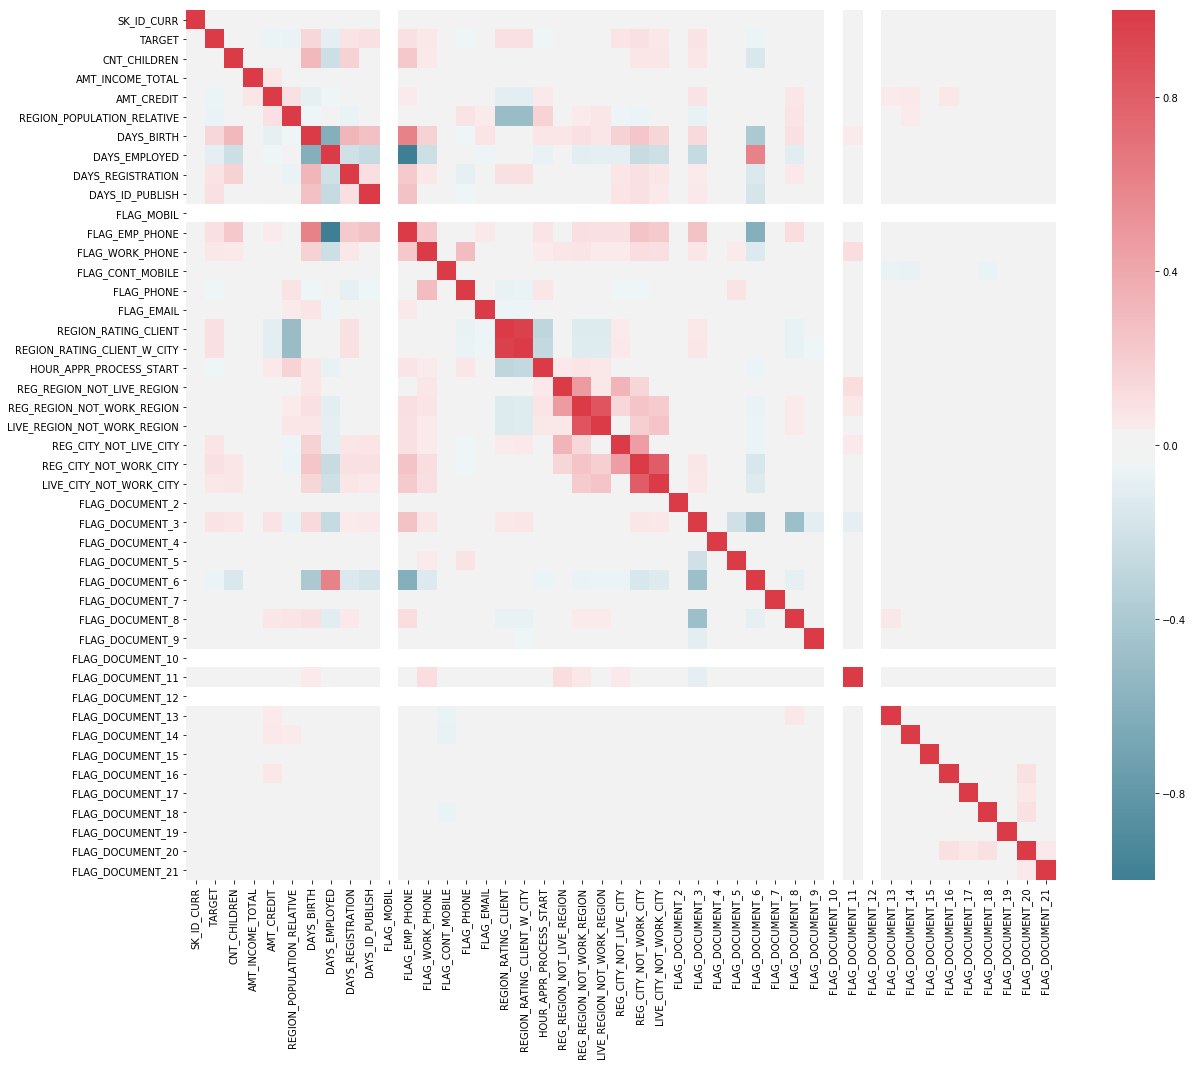

In [233]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [251]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [252]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,363533,0,Cash loans,F,N,Y,0,112500.0,219042.0,Pensioner,Lower secondary,Married,House / apartment,0.005084,-22211,365243,-11009.0,-4324,1,0,0,1,0,0,TUESDAY,16,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,260332,1,Cash loans,F,N,Y,2,135000.0,1256400.0,Working,Secondary / secondary special,Married,House / apartment,0.019689,-11748,-1060,-2228.0,-3754,1,1,0,1,0,0,WEDNESDAY,14,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,184871,0,Cash loans,F,N,Y,1,135000.0,239850.0,Working,Secondary / secondary special,Married,House / apartment,0.019689,-10709,-1677,-628.0,-625,1,1,1,1,0,0,WEDNESDAY,8,0,1,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,304858,1,Cash loans,F,N,Y,0,360000.0,1096020.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0.007330,-18275,-2310,-6646.0,-1810,1,1,0,1,0,0,MONDAY,11,0,0,Industry: type 9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,310898,0,Cash loans,F,N,Y,0,216000.0,463626.0,Pensioner,Higher education,Married,House / apartment,0.046220,-22443,365243,-365.0,-3956,1,0,0,1,0,0,FRIDAY,10,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [237]:
pd.set_option('display.max_columns',None)

In [238]:
dataset_train.head(100)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,244598,1,Cash loans,F,N,Y,1,90000.0,270000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,0.035792,-15200,-419,-9247.0,-5226,1,1,1,1,1,0,SATURDAY,10,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,182957,0,Cash loans,F,N,N,1,67500.0,180000.0,Working,Higher education,Married,With parents,0.004849,-10935,-455,-5025.0,-1420,1,1,1,1,0,0,WEDNESDAY,11,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,319229,0,Revolving loans,M,Y,N,0,90000.0,180000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-8638,-728,-3181.0,-1139,1,1,0,1,0,0,SATURDAY,9,0,0,Restaurant,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,342929,1,Cash loans,F,N,N,0,135000.0,431280.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.007330,-23202,365243,-10018.0,-4148,1,0,0,1,0,0,TUESDAY,10,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,329163,0,Cash loans,M,N,N,2,112500.0,238500.0,Working,Secondary / secondary special,Married,House / apartment,0.028663,-9641,-1777,-4171.0,-1905,1,1,0,1,0,0,FRIDAY,11,0,0,Government,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,145297,1,Cash loans,M,N,Y,1,211500.0,808650.0,Working,Secondary / secondary special,Married,House / apartment,0.010276,-15966,-2693,-5347.0,-4564,1,1,0,1,0,0,WEDNESDAY,14,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,345701,0,Cash loans,F,N,Y,0,225000.0,494550.0,Commercial associate,Higher education,Married,House / apartment,0.046220,-13146,-362,-3661.0,-4904,1,1,0,1,0,1,TUESDAY,19,0,0,Industry: type 1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,339191,1,Cash loans,F,Y,Y,0,270000.0,225000.0,Pensioner,Higher education,Married,House / apartment,0.035792,-23822,365243,-10233.0,-3998,1,0,0,1,0,0,THURSDAY,12,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,257338,0,Cash loans,F,N,Y,0,81900.0,254700.0,Working,Secondary / secondary special,Married,House / apartment,0.018850,-19427,-3520,-6108.0,-2969,1,1,1,1,1,1,FRIDAY,12,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,333702,0,Cash loans,M,Y,Y,0,315000.0,830709.0,Commercial associate,Higher education,Married,House / apartment,0.024610,-19868,-1894,-1522.0,-762,1,1,0,1,0,0,FRIDAY,15,0,0,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [239]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [256]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']
for column in columns_to_label_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column])
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded)
    index = np.arange(one_hot_encoded.shape[0])
    try:
        for i in range(0,one_hot_encoded.shape[1]):
            lst = []
            for j in range(0,one_hot_encoded[:,i].shape[0]):
                lst.append(one_hot_encoded[:,i][j])
            series = pd.Dataframe({lst)
            dataset_train = pd.concat([dataset_train,series],axis=1)
    except Exception as exception:
        print(exception)
        print(column)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))  

NAME_CONTRACT_TYPE - 50000 51
CODE_GENDER - 50000 53
FLAG_OWN_CAR - 50000 55
FLAG_OWN_REALTY - 50000 57
CNT_CHILDREN - 50000 67
NAME_INCOME_TYPE - 50000 75
NAME_EDUCATION_TYPE - 50000 80
NAME_FAMILY_STATUS - 50000 86
NAME_HOUSING_TYPE - 50000 92
ORGANIZATION_TYPE - 50000 150


In [257]:
dataset_train.shape

(50000, 150)

In [258]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,363533,0,Cash loans,F,N,Y,0,112500.0,219042.0,Pensioner,Lower secondary,Married,House / apartment,0.005084,-22211,365243,-11009.0,-4324,1,0,0,1,0,0,TUESDAY,16,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(0, 0)\t1.0",,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,"(0, 0)\t1.0","(0, 0)\t1.0",,,,,,,,,,,,,"(0, 0)\t1.0",,,,,,,,"(0, 0)\t1.0",,,"(0, 0)\t1.0",,,,,,"(0, 0)\t1.0",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"(0, 0)\t1.0"
1,260332,1,Cash loans,F,N,Y,2,135000.0,1256400.0,Working,Secondary / secondary special,Married,House / apartment,0.019689,-11748,-1060,-2228.0,-3754,1,1,0,1,0,0,WEDNESDAY,14,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(0, 0)\t1.0",,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,"(0, 0)\t1.0",,,"(0, 0)\t1.0",,,,,,,,,,,,,,,"(0, 0)\t1.0",,,,,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,,,,"(0, 0)\t1.0",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"(0, 0)\t1.0",,,,,,,,,,,,,,,
2,184871,0,Cash loans,F,N,Y,1,135000.0,239850.0,Working,Secondary / secondary special,Married,House / apartment,0.019689,-10709,-1677,-628.0,-625,1,1,1,1,0,0,WEDNESDAY,8,0,1,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(0, 0)\t1.0",,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,,,,,,,,,,,,,,"(0, 0)\t1.0",,,,,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,,,,"(0, 0)\t1.0",,,,,,,,,,"(0, 0)\t1.0",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,304858,1,Cash loans,F,N,Y,0,360000.0,1096020.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0.007330,-18275,-2310,-6646.0,-1810,1,1,0,1,0,0,MONDAY,11,0,0,Industry: type 9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(0, 0)\t1.0",,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,"(0, 0)\t1.0","(0, 0)\t1.0",,,,,,,,,,,"(0, 0)\t1.0",,,,,,,,,,,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,,,,"(0, 0)\t1.0",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"(0, 0)\t1.0",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,310898,0,Cash loans,F,N,Y,0,216000.0,463626.0,Pensioner,Higher education,Married,House / apartment,0.046220,-22443,365243,-365.0,-3956,1,0,0,1,0,0,FRIDAY,10,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(0, 0)\t1.0",,"(0, 0)\t1.0",,"(0, 0)\t1.0",,,"(0, 0)\t1.0","(0, 0)\t1.0",,,,,,,,,,,,,"(0, 0)\t1.0",,,,,,"(0, 0)\t1.0",,,,,"(0, 0)\t1.0",,,,,,"(0, 0)\t1.0",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"(0, 0)\t1.0"


In [ ]:
dtypes = dataset_train.dtypes
dtypes = dtypes[dtypes!='object']
features = list(set(dtypes.index)-set(['TARGET']))
len(features)

In [ ]:
X = dataset_train[features]
y = dataset_train['TARGET']

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [ ]:
y = np.array(y_train)

In [ ]:
count = 0
for i in range(0,len(y)):
    if y[i] == 1:
       count = count + 1
print(count)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(C=0.4)
clf.fit(X_train,y_train)

In [ ]:
prediction = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
accuracy_score(y_test,prediction)

In [ ]:
confusion_matrix(y_test,prediction)

In [ ]:
dataset_train.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier = RandomForestClassifier(verbose=2)
classifier.fit(X_train,y_train)

In [ ]:
prediction = classifier.predict(X_test)

In [ ]:
confusion_matrix(y_test,prediction).ravel()

In [ ]:
accuracy_score(y_test,prediction)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
boosting = XGBClassifier()
boosting.fit(X_train,y_train)

In [ ]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

In [ ]:
confusion_matrix(y_test,pred)

In [ ]:
from sklearn import svm

In [ ]:
#One-Hot encode data
clf = svm.SVC(gamma='scale')
clf.fit(X_train,y_train)

In [ ]:
import sklearn.gaussian_process as gp

In [ ]:
kernel = gp.kernels.Matern()
model = gp.GaussianProcess()